# Comparison to flow-cytometry csaQTLs

In [1]:
import pandas as pd
import numpy as np
import cna, pp
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as st
from argparse import Namespace
np.random.seed(0)
fig_dir = "/data/srlab/lrumker/MCSC_Project/cna-qtl/figs/"
src_folder = "/data/srlab/lrumker/MCSC_Project/cna-qtl/trait_replication/"

# From Okabe & Ito, "colorblind-friendly" palette 
from matplotlib.colors import LinearSegmentedColormap
color_dict = {'orange': '#E69F00', 'skyblue': '#56B4E9', 'green': '#009E73', 
              'yellow': '#F0E442', 'purple': '#CC79A7', 'oceanblue': '#0072B2', 
              'vermillion': '#E63d00'} # O&I use '#D55E00'

In [2]:
snps = pd.read_csv(src_folder+"replication_snp_info.csv", index_col=0)
traits = pd.read_csv(src_folder+"tested_traits.csv", index_col = 0)

snps['Test_In'] = traits.set_index('Trait_ID').loc[snps.Trait_ID.values].Test_In.values
snps['NAMPCs_Effect'] = np.repeat(np.nan, snps.shape[0])
snps['NAMPCs_SE'] = np.repeat(np.nan, snps.shape[0])

In [3]:
# Identify available SNPs in our genotyping data (consider SNP flips)
gwas_res = pd.read_table(src_folder+"plink_nampcs/nampcs."+\
                             'T1'+".assoc.linear", delim_whitespace=True)
snps['snp_available'] = [snps.ID.values[i] in gwas_res.SNP.values for i in np.arange(snps.shape[0])]
snps['snp_flipped'] = [snps.ID_flip.values[i] in gwas_res.SNP.values for i in np.arange(snps.shape[0])]
snps['snp_available'] = np.logical_or(snps.snp_available, snps.snp_flipped)
snps = snps.reset_index(drop = True)

In [4]:
for i_snp in np.arange(snps.shape[0]):
    gwas_res = pd.read_table(src_folder+"plink_nampcs/nampcs."+\
                             snps.iloc[i_snp,:].Trait_ID+".assoc.linear", delim_whitespace=True)
    if not snps.iloc[i_snp,:].snp_available: continue
    if snps.iloc[i_snp,:].snp_flipped:
        snp_id = snps.iloc[i_snp,:].ID_flip
        snps.loc[snps.index==i_snp,'NAMPCs_Effect'] = -1*gwas_res.loc[gwas_res.SNP==snp_id,:].BETA.values[0]
    else:
        snp_id = snps.iloc[i_snp,:].ID
        snps.loc[snps.index==i_snp,'NAMPCs_Effect'] = gwas_res.loc[gwas_res.SNP==snp_id,:].BETA.values[0]
    snps.loc[snps.index==i_snp,'NAMPCs_SE'] = gwas_res.loc[gwas_res.SNP==snp_id,:].SE.values[0]

In [5]:
def get_dc(vals_one, vals_two): 
    vals_one_pos = vals_one > 0
    vals_two_pos = vals_two > 0
    vals_one_neg = vals_one < 0
    vals_two_neg = vals_two < 0
    both_pos = [vals_one_pos[i] and vals_two_pos[i] for i in np.arange(len(vals_one))]
    both_neg = [vals_one_neg[i] and vals_two_neg[i] for i in np.arange(len(vals_one))]
    dc = (np.sum(both_pos)+np.sum(both_neg))/len(both_pos)
    return(dc)

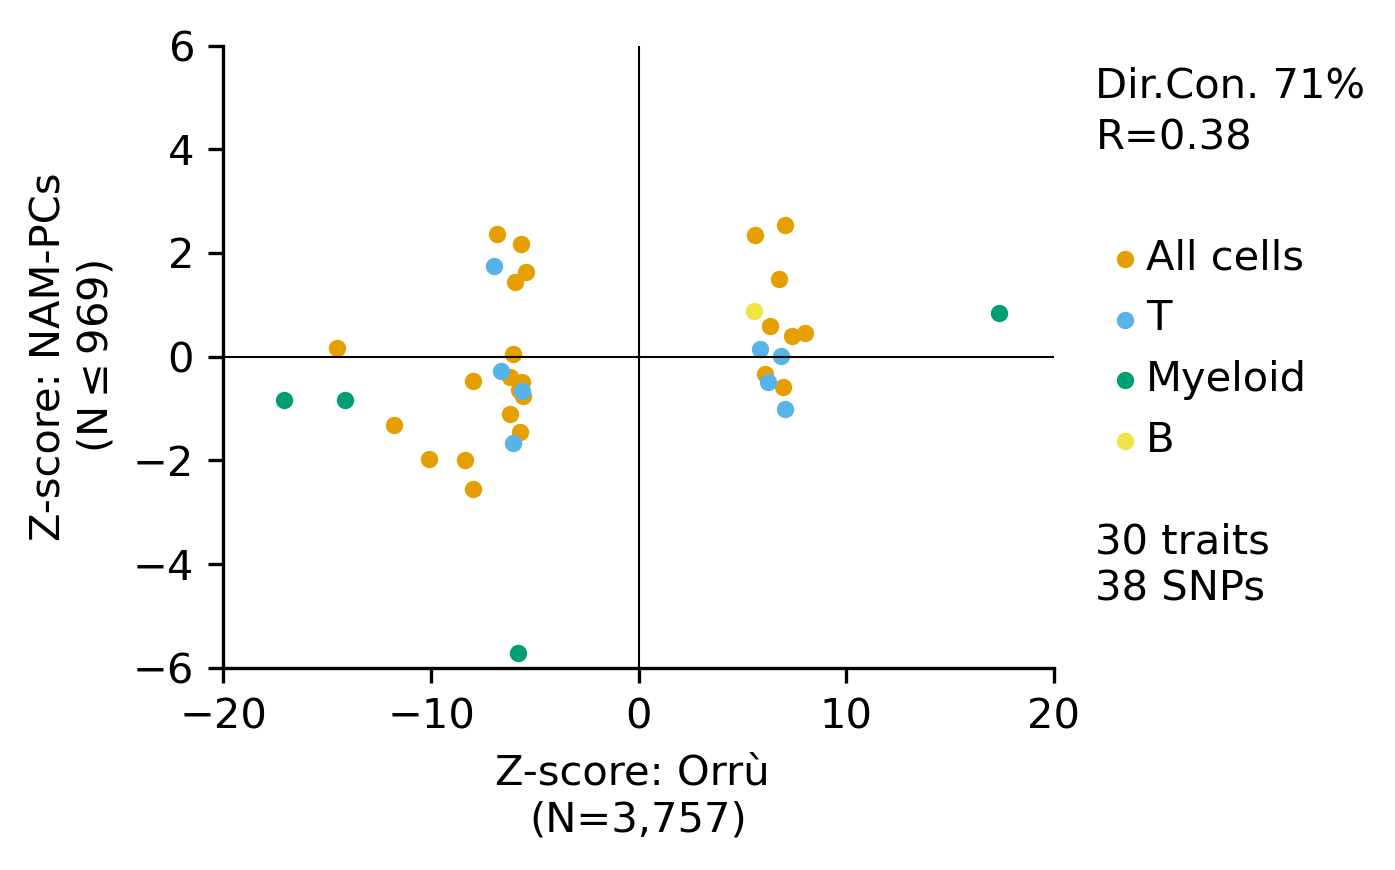

In [6]:
fig = plt.figure(figsize=(5,3), dpi = 300)

col1 = 'Effect'
col1_SE = 'SE'
col2 = 'NAMPCs_Effect'
col2_SE = 'NAMPCs_SE'
snps_refined = snps.loc[snps.snp_available,:] # Ignore snps not available in our analysis
snps_refined = snps_refined.loc[~pd.isna(snps_refined[col2]),:].reset_index()

dc = get_dc(snps_refined[col1].values, snps_refined[col2].values)
rval = np.corrcoef(snps_refined[col1].values, snps_refined[col2].values)[0,1]
x_vals = snps_refined[col1].values/snps_refined[col1_SE].values
y_vals = snps_refined[col2].values/snps_refined[col2_SE].values
for i, sel_type in enumerate(snps_refined.Test_In.value_counts().index):
    plot_label = sel_type
    if plot_label=='allcells':  plot_label="All cells"
    plt.scatter(x_vals[snps_refined.Test_In.values==sel_type], 
                y_vals[snps_refined.Test_In.values==sel_type], 
                s = 10, c = color_dict[list(color_dict.keys())[i]], label = plot_label)
plt.axvline(x=0, c = "black", lw = 0.5)
plt.axhline(y=0, c = "black", lw = 0.5)
plt.legend(loc = 'upper right', bbox_to_anchor=(1.35, 0.75), frameon=False, handletextpad=-0.5)  
plt.xlabel("Z-score: Orrù \n(N=3,757)")
plt.ylabel("Z-score: NAM-PCs\n(N$\leq$969)")
plt.text(22, 5, "Dir.Con. "+str(int(np.around(dc,2)*100))+"%")
plt.text(22, 4, "R="+str(np.around(rval,2)))

plt.xlim([-20, 20])
plt.ylim([-6, 6])

plt.text(22, -3.8, str(snps_refined.Trait_ID.value_counts().shape[0])+ " traits") # Number of unique traits included
plt.text(22, -4.7, str(snps_refined.shape[0])+ " SNPs") # How many SNPs included?

plt.gca().spines[['right', 'top']].set_visible(False)

plt.tight_layout()
plt.savefig(fig_dir+"concordance_all_traits.pdf", dpi = 300, transparent=True)
plt.savefig(fig_dir+"concordance_all_traits.png", dpi = 300, transparent=True)
plt.show()